# Calculating distances using the `lib.distances` module, and looking at hydrogen bonds

### In this notebook we'll see how to use the functions of the `distances` module to generate contact maps and   we will use them to find  hydrogen bonds.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import MDAnalysis as mda
import MDAnalysisData as data
from MDAnalysis.lib import distances
import nglview as nv
mda.__version__

'0.19.0'

Create a Universe by loading the coordinates of a PEG - poly(ethyleneglycol) chain $HO(CH2CH2)_{20}OH$ 

In [ ]:
polymer = data.datasets.fetch_PEG_1chain()

u = mda.Universe(polymer['topology'], polymer['trajectory'])

In [6]:
u=mda.Universe('tutorial_MDA/PEG.prmtop','tutorial_MDA/PEG_03_prod.nc')

In [7]:
u.trajectory

<NCDFReader tutorial_MDA/PEG_03_prod.nc with 50 frames of 13406 atoms>

We loaded a trajectory with 50 frames, but for the first part of this tutorial we'll limit ourselves to look at one frame.

### 1. Using distance_array and self_distance array to build contact maps

We can calculate quickly all possible distances between atomgroups and plot the resulting contact maps in 2D.
- **self_distance array** only takes one atomgroup
- **distance_array** takes two atomgroups and, unlike the calc_bonds/angles/dihedrals functions, they don't have to contain the same number of atoms.
- **capped_distance** and **self_capped_distance** are particularly useful when dealing with a big system: instead of looking for all possible distances, only considers atoms within a certain distance threshold.

#### 1.1 Difference between `self_distance` and `self_capped_distance`

Select all oxygen atoms belonging to the polymer:

In [39]:
C=u.atoms.select_atoms('name C*')

In [40]:
C

<AtomGroup with 40 atoms>

In [78]:
d_CC = distances.self_distance_array(C.positions, box=u.dimensions)

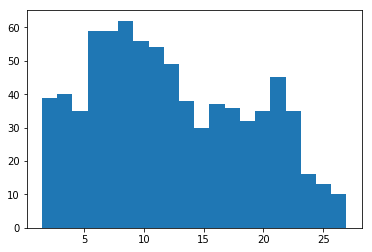

In [79]:
fig, ax = plt.subplots()
ax.hist(d_CC, bins=20)
plt.show()

The result as is doesn't look super-informative, as we only have one polymer chain and the C-C distances obviously grow with the chain length. But we can also use this function to compare different frames of a trajectory.

If we filter the `d_CC` array to exclude distances larger than 2 Å:

In [80]:
small=np.where(d_CC<2)

In [81]:
d_CC=d_CC[small]

.. We get a much more readable plot:

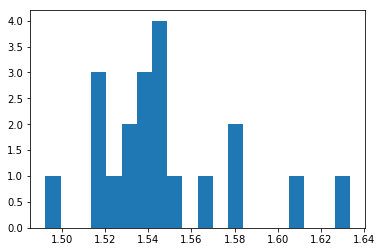

In [82]:
fig, ax = plt.subplots()
ax.hist(d_CC, bins=20)
plt.show()

But there is a faster way of doing this. `self_capped_distance` allows us to directly apply a threshold, by specifying `max_cutoff`:

In [83]:
d_CC = distances.self_capped_distance(C.positions, max_cutoff=2, box=u.dimensions)

In [84]:
d_CC

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17],
        [18, 19],
        [20, 21],
        [22, 23],
        [24, 25],
        [26, 27],
        [28, 29],
        [30, 31],
        [32, 33],
        [34, 35],
        [36, 37],
        [38, 39]]),
 array([1.5448847 , 1.53748981, 1.54263255, 1.51901582, 1.5687225 ,
        1.60642799, 1.5794497 , 1.49239203, 1.54278599, 1.53936505,
        1.63340531, 1.53800251, 1.53203517, 1.57960042, 1.51562869,
        1.5262019 , 1.52047071, 1.54710616, 1.55148517, 1.5337478 ]))

d_CC now contains a distribution of distances between neighboring carbons (cutoff=2). 
We could have used `calc_bonds`, but in this case we don't need to worry about slicing. 

Now if we plot d_CC as a histogram we should see the same result as before:

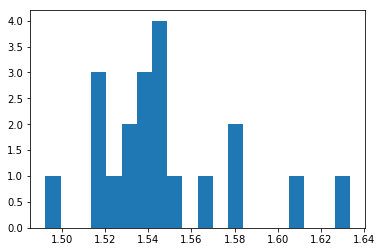

In [85]:
fig, ax = plt.subplots()
ax.hist(d_CC[1], bins=20)
plt.show()

#### 1.2 Using `distance_array` to calculate contact maps

Generate a contact map between C and O atoms.
First, make the corresponding atomselections:

In [71]:
C=u.atoms.select_atoms('name C*')
O=u.atoms.select_atoms('type os oh')

Then, call `distance_array`:

In [75]:
d_CO = distances.distance_array(C.positions, O.positions, box=u.dimensions)

In [73]:
d_CO.shape

(40, 21)

`distance_array` returns a bidimensional array that we can plot in 2D to generate a contact map:

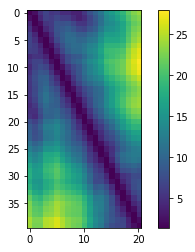

In [76]:
fig, ax = plt.subplots()
img=ax.imshow(d_CO)
plt.colorbar(img)
plt.show()

### 2. Calculate hydrogen bonds between PEG and water

MDAnalysis.analysis already contains a hbonds module, but we're gonna build a function from scratch in order to play with the *distances* methods we've seen thus far.

1) Select hydrogen bond acceptors (PEG oxygens):

In [37]:
u.trajectory[-1]

< Timestep 49 with unit cell dimensions [53.79785  43.960857 57.188725 90.       90.       90.      ] >

In [38]:
Acceptors=u.atoms.select_atoms("type os oh")

In [39]:
Acceptors

<AtomGroup with 21 atoms>

2) Select hydrogens (from water)

In [40]:
Hydrogens=u.atoms.select_atoms("type HW")

In [41]:
Hydrogens

<AtomGroup with 8842 atoms>

3) Pick the water molecules closest to the PEG chain using the **distance** (or **capped_distance**) method.

 A reasonable distance cutoff is 3 Å. We also need to consider pbc (u.dimensions).
 
 A useful feature of **distance**/**capped_distance** is that we can choose whether we need to return the distances, or only the list of Hydrogen, Acceptor pairs that satisfy our conditions. 
 
Another advantage of **capped_distance** is the speed. If your Universe is very big or you have a lot of solvent molecules, you'll see significant speedups.

In [43]:
distances.capped_distance(Hydrogens.positions, Acceptors.positions, max_cutoff=3.0, box=u.dimensions)

100 loops, best of 3: 4.45 ms per loop


Now we assign the indeces of Hydrogens and Acceptors forming the hydrogen bonds, which are returned by **capped_distance**:

In [44]:
d=distances.capped_distance(Hydrogens.positions, Acceptors.positions, max_cutoff=3, box=u.dimensions, return_distances=False)

In [49]:
Hidx, Aidx = d.T

4) Select the Oxygen donors corresponding to the Hydrogens.

Since we'll use **calc_angles** to select the suitable O-H-A interactions,
we need to have a list of Oxygen donors that corresponds to the Hydrogens (there are 2 HW per OW). We then iterate over the list of Hydrogens and recover the Oxygen atom that belongs to the same residue:

In [50]:
Donors = []
for H in Hydrogens:
    O = H.bonded_atoms[0]
    Donors.append(O)

In [51]:
Donors

[<Atom 144: O of type OW of resname WAT, resid 2 and segid SYSTEM>,
 <Atom 144: O of type OW of resname WAT, resid 2 and segid SYSTEM>,
 <Atom 147: O of type OW of resname WAT, resid 3 and segid SYSTEM>,
 <Atom 147: O of type OW of resname WAT, resid 3 and segid SYSTEM>,
 <Atom 150: O of type OW of resname WAT, resid 4 and segid SYSTEM>,
 <Atom 150: O of type OW of resname WAT, resid 4 and segid SYSTEM>,
 <Atom 153: O of type OW of resname WAT, resid 5 and segid SYSTEM>,
 <Atom 153: O of type OW of resname WAT, resid 5 and segid SYSTEM>,
 <Atom 156: O of type OW of resname WAT, resid 6 and segid SYSTEM>,
 <Atom 156: O of type OW of resname WAT, resid 6 and segid SYSTEM>,
 <Atom 159: O of type OW of resname WAT, resid 7 and segid SYSTEM>,
 <Atom 159: O of type OW of resname WAT, resid 7 and segid SYSTEM>,
 <Atom 162: O of type OW of resname WAT, resid 8 and segid SYSTEM>,
 <Atom 162: O of type OW of resname WAT, resid 8 and segid SYSTEM>,
 <Atom 165: O of type OW of resname WAT, resid 9

Now `Donors` is a list of atomgroups, but we need to reduce it to a single atomgroup:

In [52]:
Donors=sum(Donors)

In [53]:
Donors

<AtomGroup with 8842 atoms>

In [54]:
Acceptors[Aidx]

<AtomGroup with 66 atoms>

5) Calculate the O-H-A angles and count how many of them are close to 180 degrees. That's how many H-bonds we have.

Now we can check whether the angle between Oxygen donors, hydrogens and acceptors is above a critical threshold (we picked 130 degrees), and save the number of hydrogen bonds into an array:

In [56]:
a = mda.lib.distances.calc_angles(Donors.positions[Hidx], Hydrogens.positions[Hidx], Acceptors.positions[Aidx], box=u.dimensions)
a_crit = np.deg2rad(130.0)
n_hbonds = len(np.where(a > a_crit)[0])

We have 21 oxygen acceptors, so it's reasonable to expect to detect between 1 and 2 hydrogen bonds per acceptor:

In [57]:
n_hbonds

36

Now let's put it all into a function that we can then call over the entire trajectory:

In [10]:
def hbonds(hyd, acc, don):
    d = distances.capped_distance(acc.positions,
                                  hyd.positions,
                                  max_cutoff=3, 
                                  box=hyd.dimensions, 
                                  return_distances=False)
    a_idx, h_idx = d.T

    a = distances.calc_angles(don.positions[h_idx], hyd.positions[h_idx], acc.positions[a_idx], box=hyd.dimensions)
    a_crit = np.deg2rad(130.0)
    n_hbonds = len(np.where(a > a_crit)[0])
    return n_hbonds

In [59]:
hbonds(Hydrogens, Acceptors, Donors)

36

### 3. Iterating over the trajectory

When we iterate over the trajectory, the unit cell information and coordinates are automatically updated.
In order to calculate a quantity over the entire trajectory, we can create an empty list and add the property value at each frame.

We can use the function `hbonds` we just created, and write a function that iterates over the trajectory calling `hbonds` for each step:

In [11]:
def count_hbonds(u):
    hb = []
    hyd = u.atoms.select_atoms("type HW")
    acc = u.atoms.select_atoms("type os oh")
    don = []
    for H in hyd:
        O = H.bonded_atoms[0]
        don.append(O)
    don = sum(don)
    for ts in u.trajectory:
        hb.append(hbonds(hyd, acc, don))
    return hb

In [12]:
HB=count_hbonds(u)

Now we can plot the results:

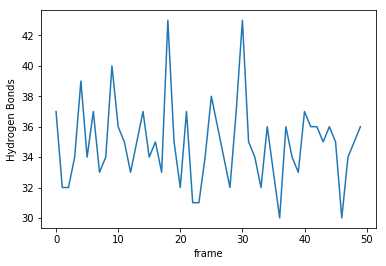

In [16]:
fig, ax =  plt.subplots()
ax.plot(HB)
ax.set_ylabel('Hydrogen Bonds')
ax.set_xlabel('frame')

plt.show()

### 4. Check the distribution of angles and distances

Our function only returns the *number* of hydrogen bonds, but it's interesting to check whether our criteria (3 Å cutoff and angle > 130 deg) are reasonable.
In order to do this, we iterate over the trajectory again but this time we keep track of all distances and angles, 
plotting them in a 2D histogram:

In [17]:
def plot_hbonds(u):
    hyd = u.atoms.select_atoms("type HW")
    acc = u.atoms.select_atoms("type os oh")
    don = []
    for H in hyd:
        O = H.bonded_atoms[0]
        don.append(O)
    don = sum(don)
    dist=[]
    ang=[]
    for ts in u.trajectory:

        idx, d = distances.capped_distance(acc.positions,
                                  hyd.positions,
                                  max_cutoff=5, 
                                  box=u.dimensions, 
                                  return_distances=True)
        Aix, Hix = idx.T
        dist.append(d)
        ang.append(distances.calc_angles(don.positions[Hix], hyd.positions[Hix], acc.positions[Aix], box=u.dimensions))
    dist=np.concatenate(dist)
    ang=np.concatenate(ang)
    return dist, ang

In [18]:
D, A = plot_hbonds(u)

In [19]:
histogram, xedges, yedges = np.histogram2d(D, np.rad2deg(A),
                                           bins=40,
                                           range=[[0.5, 5.0], [0.0, 180.0]])

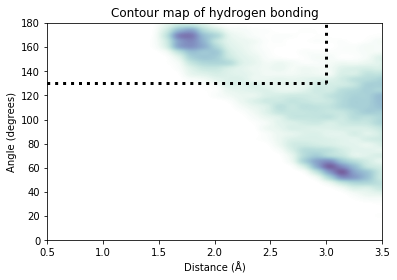

In [20]:
cmap=sns.cubehelix_palette(start=.9, rot=-.6,light=1, as_cmap=True)
# define boundaries of image
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# plot the histogram
plt.cla()
plt.imshow(histogram.T, extent=extent,cmap=cmap,
           origin='lower', aspect='auto',
           interpolation='gaussian')
# plot the geometric definition of hbonds we used
plt.plot([0.0, 3.0], [130.0, 130.0], color='k', ls=':', lw=3.0)
plt.plot([3.0, 3.0], [130.0, 180.0], color='k', ls=':', lw=3.0)


plt.xlim((0.5, 3.5))
plt.ylim((0.0, 180.0))

plt.title('Contour map of hydrogen bonding')
plt.xlabel('Distance (Å)')
plt.ylabel('Angle (degrees)')
plt.show()

It's clear that the cutoffs we impose capture quite well our hydrogen bonds; most of them are located around 170 degrees and 1.7 Å.


What is the other dark spot at 3Å / 60 degrees?